In [1]:
# download data
# !curl -k https://covid.ourworldindata.org/data/owid-covid-data.csv > dataset.csv

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal
from IPython.display import display, Math
from datetime import datetime, date

In [3]:
# constants

# data preprocessing
RUSSIA = "Russia"
ITALY = "Italy"
START_DATE = datetime(2020, 3, 3)
# linear model fit
TRAIN_SHAPE = 50

In [4]:
# my plot
def my_plot(ax, x, y, title, linewidth, color, xlabel, ylabel, is_grid=False) -> None:
    ax.plot(x, y, linewidth=linewidth, color=color)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid()


# method for heatmap plotting
def myplot_heatmap(
    ax,
    mu,
    sigma,
    model_mu,
    title,
    xlabel,
    ylabel,
    min_x=0,
    max_x=1,
    min_y=0,
    max_y=1,
    points_num=1000,
):
    X = np.linspace(min_x, max_x, points_num)
    Y = np.linspace(min_y, max_y, points_num)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    Z = multivariate_normal.pdf(pos, mean=mu, cov=sigma)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim((min_x, max_x))
    ax.set_ylim((min_y, max_y))
    ax.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    ax.scatter(model_mu[0], model_mu[1], marker="*", s=120)

    cur_mu, cur_sigma = np.array([0, 0]), 2 * np.array([[1, 0], [0, 1]])


# sampling plot
def sampling_plot(
    ax,
    func,
    mu,
    sigma,
    num_samples,
    scatter_points,
    title,
    xlabel,
    ylabel,
    min_x=0,
    max_x=100,
    min_y=0,
    max_y=10000,
    points_num=10000,
):
    # weights sampling
    w_list = np.random.multivariate_normal(mu, sigma, num_samples)

    X = np.linspace(min_x, max_x, points_num)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim((min_x, max_x))
    ax.set_ylim((min_y, max_y))
    for w in w_list:
        if func == 'exponential':
            ax.plot(X, np.exp(w[0] + w[1] * X), "c-", lw=0.4, alpha=0.5)
        if func == 'sigmoid':
            ax.plot(X, np.exp(w[0] + w[1] * X + w[2] * X ** 2), "c-", lw=0.4, alpha=0.5)
    ax.scatter(scatter_points[0], scatter_points[1], marker="*", s=80)
    ax.grid()
    return w_list

### 1. Load dataset
Load and preprocess dataset. Main points:
1. Read dataframe from csv;
2. Filter location by "Russia", choose date and *_cases columns; 

In [5]:
!ls

03-linbayes.ipynb		       README.md	 dataset.csv
03-linbayes.ipynb.txt:Zone.Identifier  ad_ml_2023.ipynb


In [6]:
dataframe = pd.read_csv("dataset.csv")
dataframe["date"] = pd.to_datetime(dataframe["date"])

# filter
dataframe = dataframe[
    (dataframe["date"] >= START_DATE) & (dataframe["location"] == RUSSIA)
][["date", "total_cases", "new_cases"]].reset_index(drop=True)
# for second task change all values = 0 in new_cases to 1
dataframe["new_cases"].replace(0, 1, inplace=True)

In [7]:
# check if we have some null's
dataframe.isna().sum()

date           0
total_cases    0
new_cases      0
dtype: int64

### 2. Exponential Regression using a Linear Model
#### a. Plotting target columns distibution
Firstly, we need to plot target columns distribution:

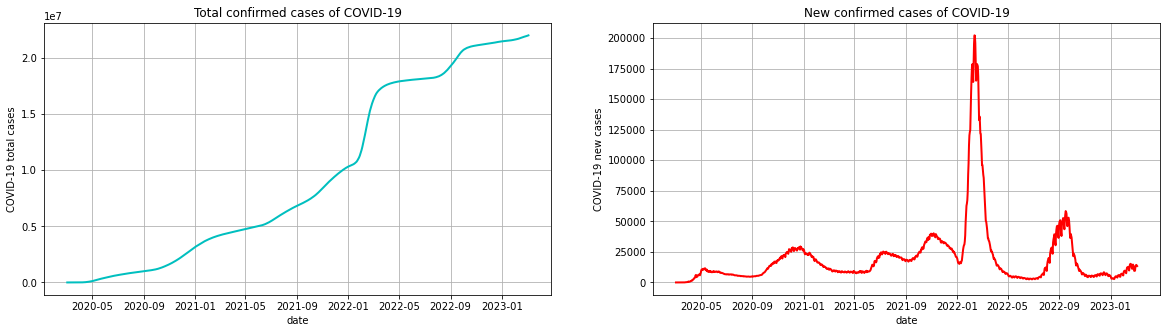

In [8]:
x, total_cases, new_cases = (dataframe[col].to_list() for col in dataframe.columns)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
# show total cases
my_plot(
    ax1,
    x,
    total_cases,
    "Total confirmed cases of COVID-19",
    2,
    "c",
    "date",
    "COVID-19 total cases",
    is_grid=True,
)
# show new cases
my_plot(
    ax2,
    x,
    new_cases,
    "New confirmed cases of COVID-19",
    2,
    "r",
    "date",
    "COVID-19 new cases",
    is_grid=True,
)
plt.show()

As we can see, data has a non-uniform distribution, which does't have exponential type of dependency. But, there are many peaks in different peroids of timeline, where number of cases grow rapidly, drop sharply. I think, the best way to analyse new confirmed cases data is using polynomial regression or gaussian process regression.

#### b. Exponentian model learning
Information from the first Google site :)

Sometimes linear regression can be used with relationships that are not inherently linear, but can be made to bemlinear after a transformation. In particular, we consider the following exponential model: <br>
$$
y = \alpha e^{\beta x}
$$
Taking the natural log (see Exponentials and Logs) of both sides of the equation, we have the following equivalent equation:
$$
\ln y = \ln \alpha + \beta x
$$
This equation has the form of a linear regression model (with adding $\varepsilon$):
$$
y' = \alpha ' + \beta x + \varepsilon
$$
Source: https://real-statistics.com/regression/exponential-regression-models/exponential-regression/

In [9]:
train_df, test_df = dataframe[:TRAIN_SHAPE], dataframe[:TRAIN_SHAPE]

# new_cases model
train_y = train_df["new_cases"].to_numpy()
log_train_y = np.log(train_y)
train_x = np.arange(TRAIN_SHAPE).reshape(-1, 1)

exp_model = LinearRegression()
exp_model.fit(train_x, log_train_y)

display(
    Math(
        r"Model: \\ y = e^{{{0} * x + {1}}}".format(
            round(exp_model.coef_[0], 3), round(exp_model.intercept_, 3)
        )
    )
)

<IPython.core.display.Math object>

In [10]:
# Let's choose some variance for prior distribution, which will have trained w-values inside it
sigma_0 = 1
sigma_matrix_0 = sigma_0 * np.diag((1, 1))

Noise variance - sample variance of train data, obtained after likelihood maximization:
$$
\sigma ^2_{ML} = \frac{1}{N}\sum ^N_{n=1}(t_n - \omega ^T_{ML}\phi(x_n))^2
$$
Source: https://logic.pdmi.ras.ru/~sergey/teaching/mlhse18/03-linregr.pdf, page 12.

In [11]:
# noise variance
sigma_noise = np.power((exp_model.predict(train_x) - log_train_y), 2).sum() / TRAIN_SHAPE
sigma_matrix_noise = sigma_noise * np.diag((1, 1))

display(Math(r"\sigma = {0}".format(round(sigma_noise, 3))))

<IPython.core.display.Math object>

Posterior model parameter distibution:
$$
p(\textbf{w}|\textbf{t}) = \mathcal{N}(\omega |\mu_N,\Sigma_N)
\newline\mu_N = \Sigma_N(\Sigma^{-1}_0\mu_0 + \frac{1}{\sigma^2}\Phi^2\textbf{t})
\newline\Sigma_N = (\Sigma^{-1}_0 + \frac{1}{\sigma^2}\Phi^2\Phi)^{-1}
$$
Source: https://logic.pdmi.ras.ru/~sergey/teaching/mlhse18/03-linregr.pdf, page 49.

In [12]:
# posterior distribution parameters
train_x_with_bias = np.hstack((np.ones(train_x.shape), train_x))

sigma_matrix = np.linalg.inv(
    sigma_matrix_0 + train_x_with_bias.T.dot(train_x_with_bias) / sigma_noise**2
)
mu_matrix = sigma_matrix.dot(train_x_with_bias.T.dot(log_train_y) / sigma_noise**2)

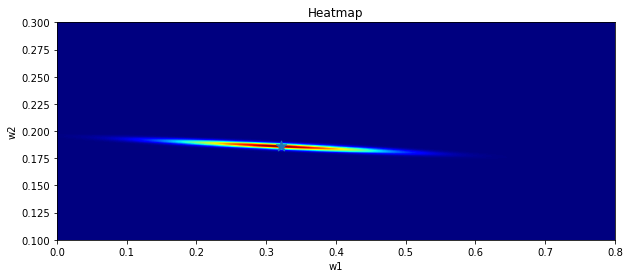

In [13]:
figure, ax = plt.subplots(1, 1, figsize=(10, 4))
myplot_heatmap(
    ax, 
    mu_matrix,
    sigma_matrix,
    [exp_model.intercept_, exp_model.coef_[0]],
    "Heatmap",
    "w1",
    "w2",
    min_x=0,
    max_x=0.8,
    min_y=0.1,
    max_y=0.3,
)
plt.show()

#### c. Sampling:
Sample several weights from aposterior distribution and use their mean for predictions:

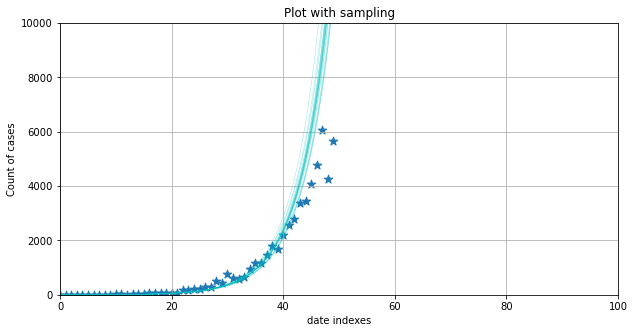

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

w_list = sampling_plot(
    ax,
    'exponential',
    mu_matrix,
    sigma_matrix,
    20,
    (train_x, train_y),
    "Plot with sampling",
    "date indexes",
    "Count of cases",
    min_x=0,
    max_x=100,
    min_y=0,
    max_y=10000,
    points_num=10000,
)
plt.show()

Target dates values:

In [15]:
target_dates_df = pd.DataFrame(
    [
        datetime(2020, 5, 1, 0, 0),
        datetime(2020, 6, 1, 0, 0),
        datetime(2020, 9, 1, 0, 0),
    ],
    columns=["date"],
)
target_dates_df["date_index"] = target_dates_df["date"].apply(
    lambda x: (x - START_DATE).days
)
target_dates_df["total_cases_prediction"] = target_dates_df["date_index"].apply(
    lambda x: np.round(np.exp(w_list[:, 0] + w_list[:, 1] * x).mean(), 0)
)
target_dates_df = target_dates_df.merge(dataframe, on="date")[
    ["date", "total_cases_prediction", "total_cases"]
]
target_dates_exp_df = target_dates_df.copy()
target_dates_df

,date,total_cases_prediction,total_cases
0,2020-05-01,8.388600e+04,114431.0
1,2020-06-01,2.830519e+07,414328.0
2,2020-09-01,9.795849e+14,997072.0


As we can see from sampling and prediction - exponential regression gives bad results for this dataset. The main reason is that it can't work with ups and downs of COVID-19 intensity. Exponential model is good for data with fast growth, like we can see in train dataset (see plot above).

### 3. Sigmoid Regression using a Linear Model with Gaussian function:
#### a. Choosing logic for sigmoid model training: 
$$
\Phi(x) = \frac{1}{\sqrt{2\pi}} 
  \int_{-\infty}^{x} e^{-\frac{t^2}{2}}dt
$$
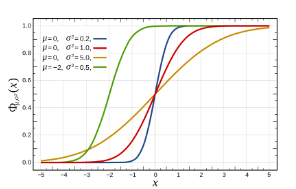
Distribution density is derivative - $\Phi'(x)$. It will be proportional to exponent with square of x: 
$$
\Phi'(x) \propto e^{\omega x^2}
$$ 
So, we can use linear model to predict: 
$$
len(y) = \omega_0  + \omega_1x+\omega_2x^2
$$
and 
to predict model with gaussian density and distribution function.

In [16]:
train_df, test_df = dataframe[:TRAIN_SHAPE], dataframe[:TRAIN_SHAPE]

# new_cases model
train_y = train_df["new_cases"].to_numpy()
log_train_y = np.log(train_y)
train_x = np.arange(TRAIN_SHAPE).reshape(-1, 1)
train_x = np.hstack((train_x, train_x**2))

sigmoid_model = LinearRegression()
sigmoid_model.fit(train_x, log_train_y)

display(
    Math(
        r"Model: \\ y = e^{{{0} * x^2 + {1} * x + {2}}}".format(
            round(sigmoid_model.coef_[1], 3),
            round(sigmoid_model.coef_[0], 3),
            round(sigmoid_model.intercept_, 3),
        )
    )
)

<IPython.core.display.Math object>

#### b. Get posterior parameters:

In [17]:
# Let's choose some variance for prior distribution, which will have trained w-values inside it
sigma_0 = 1
sigma_matrix_0 = sigma_0 * np.diag((1, 1, 1))

In [18]:
# noise variance
sigma_noise = np.power((sigmoid_model.predict(train_x) - log_train_y), 2).sum() / TRAIN_SHAPE
sigma_matrix_noise = sigma_noise * np.diag((1, 1))

display(Math(r"\sigma = {0}".format(round(sigma_noise, 3))))

<IPython.core.display.Math object>

In [19]:
# posterior distribution parameters
train_x_with_bias = np.hstack((np.ones((train_x.shape[0], 1)), train_x))

sigma_matrix = np.linalg.inv(
    sigma_matrix_0 + train_x_with_bias.T.dot(train_x_with_bias) / sigma_noise**2
)
mu_matrix = sigma_matrix.dot(train_x_with_bias.T.dot(log_train_y) / sigma_noise**2)

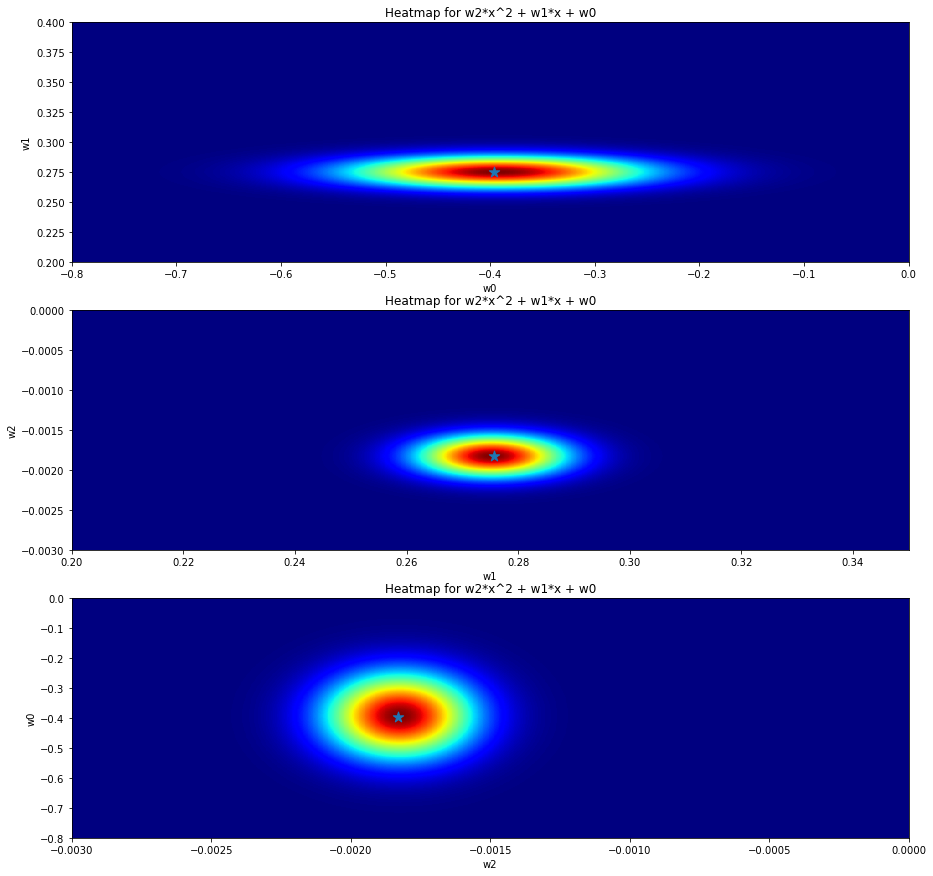

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

myplot_heatmap(
    axs[0], 
    mu_matrix[[0, 1]],
    sigma_matrix[[0, 1], [0, 1]],
    [sigmoid_model.intercept_, sigmoid_model.coef_[0]],
    "Heatmap for w2*x^2 + w1*x + w0",
    "w0",
    "w1",
    min_x=-0.8,
    max_x=0,
    min_y=0.2,
    max_y=0.4,
)

myplot_heatmap(
    axs[1], 
    mu_matrix[[1, 2]],
    sigma_matrix[[1, 2], [1, 2]],
    [sigmoid_model.coef_[0], sigmoid_model.coef_[1]],
    "Heatmap for w2*x^2 + w1*x + w0",
    "w1",
    "w2",
    min_x=0.2,
    max_x=0.35,
    min_y=-0.003,
    max_y=0,
)

myplot_heatmap(
    axs[2], 
    mu_matrix[[2, 0]],
    sigma_matrix[[2, 0], [2, 0]],
    [sigmoid_model.coef_[1], sigmoid_model.intercept_],
    "Heatmap for w2*x^2 + w1*x + w0",
    "w2",
    "w0",
    min_x=-0.003,
    max_x=0,
    min_y=-0.8,
    max_y=0,
)
plt.show()

#### Sampling:

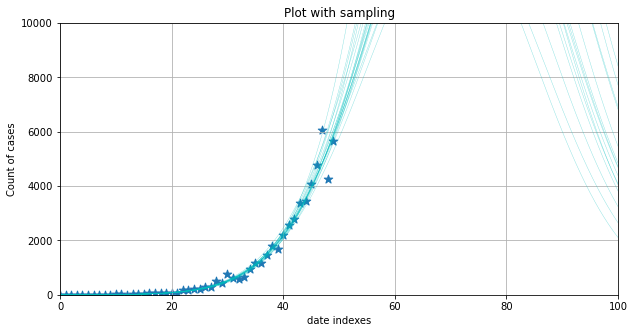

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))

w_list = sampling_plot(
    ax,
    'sigmoid',
    mu_matrix,
    sigma_matrix,
    20,
    (train_x[:, 0], train_y),
    "Plot with sampling",
    "date indexes",
    "Count of cases",
    min_x=0,
    max_x=100,
    min_y=0,
    max_y=10000,
    points_num=10000,
)
plt.show()

In [22]:
target_dates_df = pd.DataFrame(
    [
        datetime(2020, 5, 1, 0, 0),
        datetime(2020, 6, 1, 0, 0),
        datetime(2020, 9, 1, 0, 0),
    ],
    columns=["date"],
)
target_dates_df["date_index"] = target_dates_df["date"].apply(
    lambda x: (x - START_DATE).days
)
target_dates_df["total_cases_prediction"] = target_dates_df["date_index"].apply(
    lambda x: np.round(np.exp(w_list[:, 0] + w_list[:, 1] * x + w_list[:, 2] * x**2).mean(), 0)
)
target_dates_df = target_dates_df.merge(dataframe, on="date")[
    ["date", "total_cases_prediction", "total_cases"]
]
target_dates_sigm_df = target_dates_df.copy()
target_dates_df

,date,total_cases_prediction,total_cases
0,2020-05-01,13413.0,114431.0
1,2020-06-01,18608.0,414328.0
2,2020-09-01,0.0,997072.0


Let's analyse predictions of today COVID-19 cases:

In [23]:
today = (lambda x: (datetime.strptime(x, '%Y-%m-%d') - START_DATE).days)('2023-03-11') 
by_today_array = np.array([[1, today, today**2] for today in np.arange(1, today)])

In [24]:
samples_num = 1000

w_sample = np.random.multivariate_normal(mu_matrix, sigma_matrix, samples_num)
total_cases = []
for w in w_sample:
    cumsum_list = np.cumsum([np.exp(np.dot(w, i)) for i in by_today_array])
    total_cases.append(cumsum_list[-1])

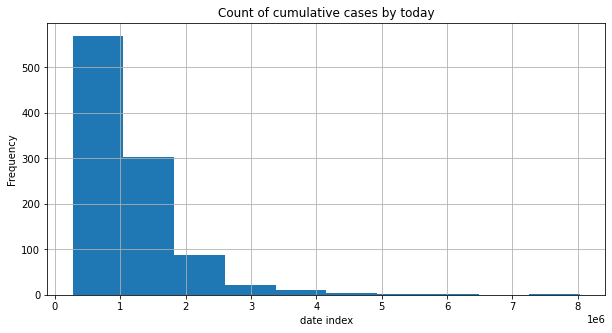

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.hist(total_cases)
ax.set_title("Count of cumulative cases by today")
ax.set_xlabel("date index")
ax.set_ylabel("Frequency")
ax.grid()
plt.show()

In [26]:
np.percentile(total_cases, 90)

1988083.5919943028

In [27]:
np.percentile(total_cases, 10)

512319.7328873313

So optimistic prediction, now we have total ~ 22411108.

#### Thinks:
Exponential function better work with fast growth in short period, but if target data have ups and downs, model breaks. Gaussian function can work with first peak in data, but, in this dataset we have big amounts of data changes, so, after some time it can go into null (results of predictions below).

In [28]:
target_dates_exp_df.merge(target_dates_sigm_df, on=['date'], suffixes=('_exponential', '_sigmoid'))

,date,total_cases_prediction_exponential,total_cases_exponential,total_cases_prediction_sigmoid,total_cases_sigmoid
0,2020-05-01,8.388600e+04,114431.0,13413.0,114431.0
1,2020-06-01,2.830519e+07,414328.0,18608.0,414328.0
2,2020-09-01,9.795849e+14,997072.0,0.0,997072.0


### 4. Other country analysis:
As I remember, Italy one of the first got big amount of COVID-19 cases, but at march there was a decrease in diseases. It's interesting to look at sigmoid model behavior with none-null-start data.

In [29]:
dataframe = pd.read_csv("dataset.csv")
dataframe["date"] = pd.to_datetime(dataframe["date"])

# filter
dataframe = dataframe[
    (dataframe["date"] >= START_DATE) & (dataframe["location"] == ITALY)
][["date", "total_cases", "new_cases"]].reset_index(drop=True)
# for second task change all values = 0 in new_cases to 1
dataframe["new_cases"].replace(0, 1, inplace=True)

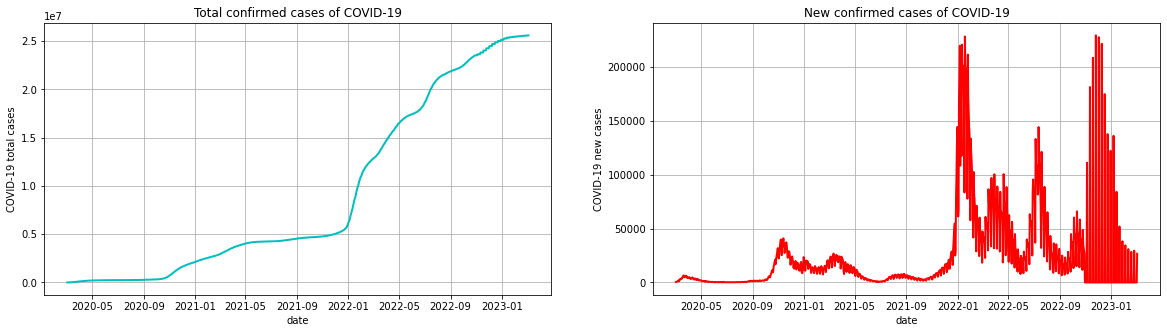

In [30]:
x, total_cases, new_cases = (dataframe[col].to_list() for col in dataframe.columns)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
# show total cases
my_plot(
    ax1,
    x,
    total_cases,
    "Total confirmed cases of COVID-19",
    2,
    "c",
    "date",
    "COVID-19 total cases",
    is_grid=True,
)
# show new cases
my_plot(
    ax2,
    x,
    new_cases,
    "New confirmed cases of COVID-19",
    2,
    "r",
    "date",
    "COVID-19 new cases",
    is_grid=True,
)
plt.show()

In [31]:
train_df, test_df = dataframe[:TRAIN_SHAPE], dataframe[:TRAIN_SHAPE]

# new_cases model
train_y = train_df["new_cases"].to_numpy()
log_train_y = np.log(train_y)
train_x = np.arange(TRAIN_SHAPE).reshape(-1, 1)
train_x = np.hstack((train_x, train_x**2))

sigmoid_model = LinearRegression()
sigmoid_model.fit(train_x, log_train_y)

display(
    Math(
        r"Model: \\ y = e^{{{0} * x^2 + {1} * x + {2}}}".format(
            round(sigmoid_model.coef_[1], 3),
            round(sigmoid_model.coef_[0], 3),
            round(sigmoid_model.intercept_, 3),
        )
    )
)

<IPython.core.display.Math object>

In [32]:
# Let's choose some variance for prior distribution, which will have trained w-values inside it
sigma_0 = 1
sigma_matrix_0 = sigma_0 * np.diag((1, 1, 1))

In [33]:
# noise variance
sigma_noise = np.power((sigmoid_model.predict(train_x) - log_train_y), 2).sum() / TRAIN_SHAPE
sigma_matrix_noise = sigma_noise * np.diag((1, 1))

display(Math(r"\sigma = {0}".format(round(sigma_noise, 3))))

<IPython.core.display.Math object>

In [34]:
# posterior distribution parameters
train_x_with_bias = np.hstack((np.ones((train_x.shape[0], 1)), train_x))

sigma_matrix = np.linalg.inv(
    sigma_matrix_0 + train_x_with_bias.T.dot(train_x_with_bias) / sigma_noise**2
)
mu_matrix = sigma_matrix.dot(train_x_with_bias.T.dot(log_train_y) / sigma_noise**2)

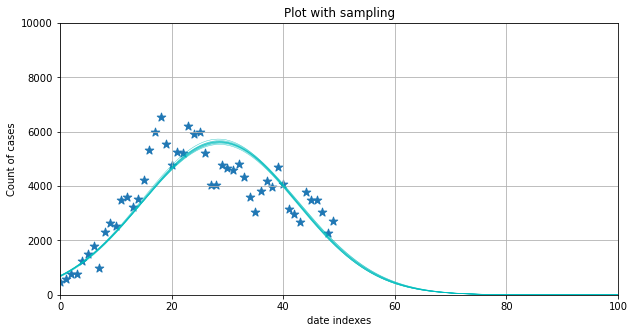

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))

w_list = sampling_plot(
    ax,
    'sigmoid',
    mu_matrix,
    sigma_matrix,
    20,
    (train_x[:, 0], train_y),
    "Plot with sampling",
    "date indexes",
    "Count of cases",
    min_x=0,
    max_x=100,
    min_y=0,
    max_y=10000,
    points_num=10000,
)
plt.show()

#### Ooops...
My memory about 2020-year events was wrong, but no we have illustration how sigmoid model works with peak.